# Proyecto- Segmentación en grupos de acuerdo a características de pacientes

**Integrantes**: Maria Fernanda De La Hoz, Silvana Sandoval y Gabriela Soler 


## Objetivo del proyecto

Este proyecto tiene el objetivo de incorporar herramientas de Inteligencia Artificial para incrementar la eficiencia de la prestación de servicios a los usuarios en las diferentes IPS asociadas, teniendo en cuenta que en el contexto del triage, la agrupación puede ser útil para la toma de decisiones.

## Importación de las librerías relevantes

Este primer paso es esencial ya que estas librerías son las que nos permitirán ejecutar los algoritmos y hacer los análisis relevantes para comprender cuál de los modelos que usamos es el óptimo para solucionar el problema de este proyecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Importación de los datos

In [2]:
data = pd.read_csv("202420_Laboratorio 2 - Agrupación_202420_Laboratorio_2_-_Agrupación_data.csv", encoding="latin1", sep=",")

## Entedimiento de los datos

Para empezar los pasos de entendimiento de los datos, es importante ver qué filas lo constituyen.

In [3]:

print(data.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...    BT  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...  36.2        98.0               2   
1      1         4  140.0  ...  36.3        99.0               3   
2      1         3  100.0  ...  36.4        98.0               4   
3      1         4  120.0  ...  36.5        99.0               4   
4      0    #BOÃ!  143.0  ...  38.1         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain           

Ahora, vamos a ver el número de registros y de columnas con el que contamos. Esto nos permitirá saber, en total, qué datos tenemos para entrenar los modelos de los que haremos uso en este laboratorio.

In [4]:
data.shape

(1000, 23)

Luego, haremos uso de la función describe() de los DataFrames de Pandas. Esto se hace con el fin de entender cuáles son las medidas de tendencia central (media, desviación estandar, moda), maximos, mínimos y los quartiles de las variables númericas. Lo anterior da una primera aproximación sobre cómo están organizados los datos

In [5]:
print(data.describe())

             Grupo         Sexo         Edad  Modo_Llegada     Lesion  \
count  1000.000000  1000.000000  1000.000000   1000.000000  1000.0000   
mean      1.450000     1.514000    53.892000      2.811000     1.2000   
std       0.497743     0.500054    19.826483      0.796186     0.4002   
min       1.000000     1.000000    16.000000      1.000000     1.0000   
25%       1.000000     1.000000    36.000000      2.000000     1.0000   
50%       1.000000     2.000000    56.000000      3.000000     1.0000   
75%       2.000000     2.000000    70.250000      3.000000     1.0000   
max       2.000000     2.000000    94.000000      7.000000     2.0000   

       Estado_Mental        Dolor         SBP         DBP          HR  \
count    1000.000000  1000.000000  983.000000  979.000000  988.000000   
mean        1.103000     0.562000  133.485249   79.566905   84.400810   
std         0.431946     0.496389   27.156136   15.174593   16.297428   
min         1.000000     0.000000   50.000000   31

### Outliers

Ahora vamos a hacer diagramas de cajas y bigotes para el data frame. Esto lo hacemos para poder identificara aquellas clases que tienen outliers muy extremos, lo cual nos permitirá determinar el tratamiento correcto para estos datos ya que pueden ocasionar problemas en algortimos como K-Means que son sensibles a los datos extremos.

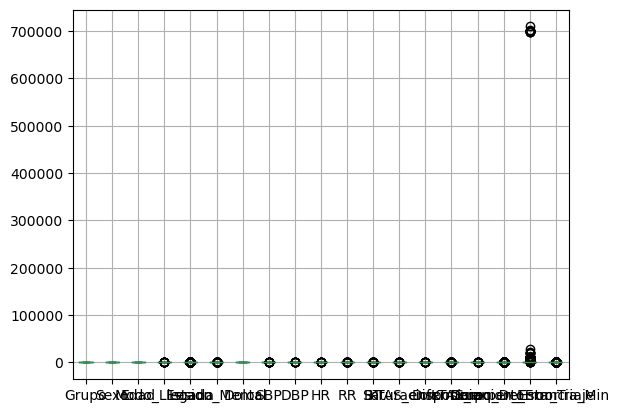

<Figure size 5000x4000 with 0 Axes>

In [6]:
data.boxplot()
plt.figure(figsize=(50, 40))
# Show the plot
plt.show()

Ahora veremos en detalle aquellas clases que tienen outliers para poder determinar si son datos muy diferentes al resto de los datos y se debe hacer una limpieza o si, por el contrario, se pueden dejar para que se pueda hacer una agrupación a partir de estos. Además, esto  nos permitirá identificar si hay valores que no deberían estar en el conjunto de datos ya que se salen de los rangos permitidos. Para esto veremos las clases de Duración_Estancia_Min, Disposicion, HR, SBP, Lesion y Estado Mental.

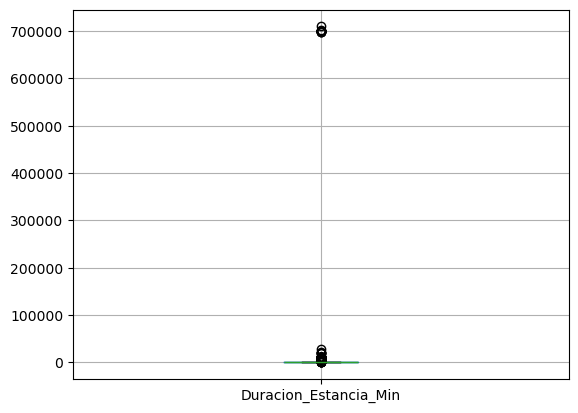

In [7]:
data.boxplot(column=['Duracion_Estancia_Min'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Duracion_Estancia_Min'].quantile(0.25)
Q3 = data['Duracion_Estancia_Min'].quantile(0.75)
IQR = Q3 - Q1





Como se puede ver en la gráfica de Duración_Estancia_Min, si bien hay bastantes outliers, la mayoría estan por debadjo de los 50 mil minutos y no están tan lejanos del diagrama de cajas y bigotes. Sin embargo, hay unos cuantos datos que estan sober 600000 minutos que son bastante lejanos a los demás datos. Esto sería un problema para los algoritmos que vamos a entrenar ya que uno de ellos usa la media de los datos, por lo cual todos los outliers de esta clase que estén por encima de 50000 minutos se eliminarán.

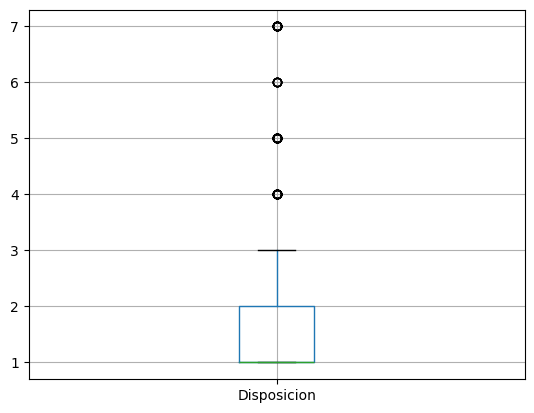

In [8]:
data.boxplot(column=['Disposicion'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Disposicion'].quantile(0.25)
Q3 = data['Disposicion'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Disposicion hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable es categórica, por lo cual estos número representan el estado en el que llega el paciente y qué tipo de atención requiere.

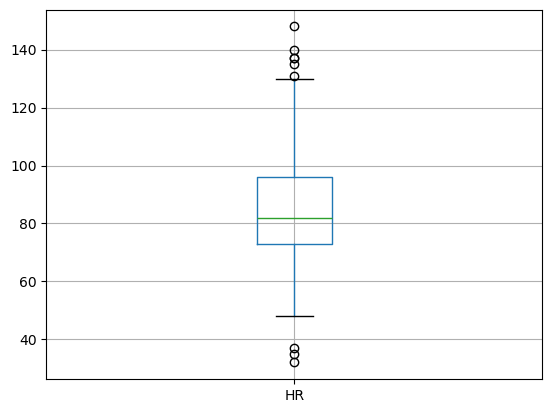

In [9]:
data.boxplot(column=['HR'])
plt.show()

# Identify outliers based on IQR
Q1 = data['HR'].quantile(0.25)
Q3 = data['HR'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de HR hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones.

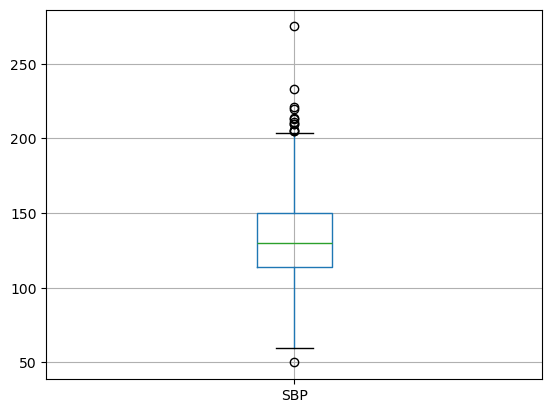

In [10]:
data.boxplot(column=['SBP'])
plt.show()

# Identify outliers based on IQR
Q1 = data['SBP'].quantile(0.25)
Q3 = data['SBP'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de SBP hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones.

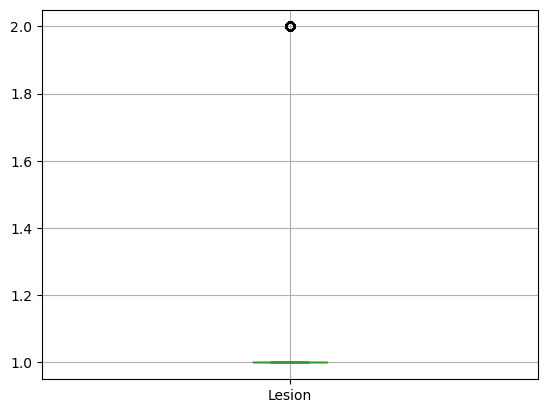

In [11]:
data.boxplot(column=['Lesion'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Lesion'].quantile(0.25)
Q3 = data['Lesion'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Lesion hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable se considera categórica con 1= sí hay lesión y 2=No hay.

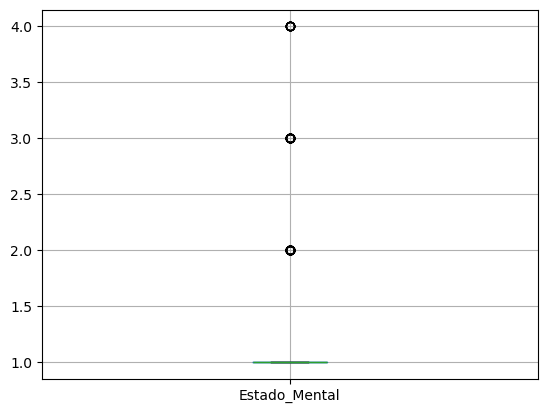

In [12]:
from matplotlib import pyplot as plt


data.boxplot(column=['Estado_Mental'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Estado_Mental'].quantile(0.25)
Q3 = data['Estado_Mental'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Estado Mental hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable se considera categórica donde los números representan los diferentes estados mentales en los que llegó el paciente, la cual es información valiosa.

### Datos duplicados y nulos

Ahora veremos los datos duplicados y nulos. Comprobar el número de registros que tienen estos datos es sumamente importante ya que los primero pueden causar sesgos en los modelos, y los segundos tienen que ser tratados de alguna manera para que tengan un comportamiento similar a los demás datos.

In [13]:
data.isnull().sum()

Grupo                         0
Sexo                          0
Edad                          0
Modo_Llegada                  0
Lesion                        0
Queja_Principal               0
Estado_Mental                 0
Dolor                         0
dolor_NRS                     0
SBP                          17
DBP                          21
HR                           12
RR                           15
BT                           11
Saturacion                  556
KTAS_enfermera                0
Diagnostico_En_Urgencias      1
Disposicion                   0
KTAS_experto                  0
Grupo_De_Error                0
Duracion_Estancia_Min         0
Duracion_KTAS_Min             0
Error_Triaje                  0
dtype: int64

Vamos a ver el porcentaje de datos faltantes para decidir si borrar columnas o reemplazar por medias.

In [14]:
features = ["Sexo", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "SBP", "DBP", "HR", "RR", "Saturacion", "Disposicion"]

data[["Duracion_Estancia_Min"] + features].isnull().sum() / data.shape[0] * 100

Duracion_Estancia_Min     0.0
Sexo                      0.0
Modo_Llegada              0.0
Lesion                    0.0
Estado_Mental             0.0
Dolor                     0.0
SBP                       1.7
DBP                       2.1
HR                        1.2
RR                        1.5
Saturacion               55.6
Disposicion               0.0
dtype: float64

Ahora, revisaremos los duplicados para tener una idea de cuantos registros serán borrados para evitar sesgos

In [15]:
duplicate_rows = data.duplicated().sum()
print(f"Número de filas duplicadas: {duplicate_rows}")

Número de filas duplicadas: 33


### Número de categorias en las variables categóricas con tipo de datos Object.

Esto se hace con el fin de saber cuántas categorías tienen las variables categoricas para poder decidir si se reemplazan con un encoder o si simplemente se elimina la columna ya que estas, al ser tipo object, no son procesadas por los algoritmos de agrupación como K Means que solo trabajan con datos numéricos. Las categorias con las trabajaremos son: Queja_Principal, dolor_NRS, y Diagnostico_En_Urgencias.

In [16]:
data["Queja_Principal"].value_counts()

Queja_Principal
abd pain                               62
dizziness                              53
dyspnea                                45
ant. chest pain                        37
fever                                  29
                                       ..
hand laceration                         1
Sexual Abuse of Adult                   1
laceration, scalp                       1
right lower quadrant abdominal pain     1
otalgia, Rt.                            1
Name: count, Length: 347, dtype: int64

In [17]:
data["dolor_NRS"].value_counts()

dolor_NRS
#BOÃ!    440
3         209
4         111
5         109
6          59
2          31
7          27
8           8
10          3
1           2
9           1
Name: count, dtype: int64

In [18]:
data["Diagnostico_En_Urgencias"].value_counts()

Diagnostico_En_Urgencias
Acute gastroenteritis                                   39
Headache                                                23
Dizziness                                               20
Unspecified abdominal pain                              19
Ischaemic chest pain                                    17
                                                        ..
Colon cancer, sigmoid                                    1
Postnasal drip syndrome                                  1
Other specified diabetes mellitus, with hypoglycemia     1
Open wound of finger(s) without damage to nail           1
Traumatic secondary and recurrent haemorrhage            1
Name: count, Length: 489, dtype: int64

Como se puede apreciar, en general, se tienen más de 10 o más categorias, una de ellas siendo datos nulos. Esto cuando se utiliza un encoder puede causar que hayan demasiados números, lo cual puede causar problemas en el momento de hacer la agrupación, por lo cual sería recomendable borrarlos.

## Limpieza de los datos

### Análisis de las variables para la implementación del proyecto

*Variables Categóricas:*

Grupo: Es una variable importante porque parece clasificar a los pacientes en grupos que queremos optimizar.

Sexo, Modo_Llegada, Lesión, Estado_Mental, Dolor: Estas variables categorizadas probablemente influyan en la clasificación y deberían codificarse adecuadamente.

*Variables de Severidad:*
KTAS_Enfermera y KTAS_Experto: Estas escalas son importantes para evaluar la urgencia de los pacientes. Es clave tenerlas en cuenta en el modelo de agrupamiento.

Disposición: Esta variable refleja qué pasó con el paciente después de la evaluación, lo que podría ser útil para encontrar patrones en los resultados del tratamiento.

*Variables Numéricas:*

Las variables fisiológicas como SBP (Presión Arterial Sistólica), DBP (Presión Diastólica), HR (Frecuencia Cardíaca), RR (Frecuencia Respiratoria), BT (Temperatura Corporal), y Saturación (Oxígeno) son críticas para describir el estado físico del paciente.

Variables de tiempo como Duración_Estancia_Min y Duración_KTAS_Min también son importantes porque podrían ayudar a analizar la eficiencia de la atención.

*Variables que podrían tener ruido:*

Grupo_Error, Error_Triaje: Si estamos trabajando para hacer agrupamientos basados en la condición de los pacientes, estas columnas relacionadas con errores podrían introducir ruido o ser útiles para analizar el rendimiento de los grupos predichos.

### Manejo de variables faltantes

Para las variables críticas (por ejemplo, las fisiológicas y de severidad), podemos usar imputación. Es por esto que identificaremos cuáles columnas tienen valores faltantes y cuántos faltan:

Para las variables fisiológicas con pocos valores faltantes (SBP, DBP, HR, RR, BT):
Podemos usar imputación con la mediana. La mediana es robusta a valores atípicos y adecuada para variables fisiológicas.

Para la variable Saturacion, que tiene más del 50% de los datos faltantes:
Podríamos considerar imputar con la mediana también, pero como tiene demasiados valores faltantes, otra opción sería eliminar esta columna si no es esencial para el análisis.

Para Diagnostico_En_Urgencias, que tiene solo un valor faltante:
Imputar con el valor más frecuente será una estrategia razonable.

### Copia de los datos

Para empezar la limpieza de los datos, vamos a hacer una copia de los datos para evitar dañar el conjunto original.

In [19]:
#Iniciaremos creando una copia de los datos para realizar un preprocesamiento
dataCopy = data.copy()

Luego, vamos a eliminar los datos duplicados. Esto se hace con el objetivo de evitar sesgos en el modelo.

In [20]:
dataCopy = dataCopy.drop_duplicates()

Después de borrar los duplicados, procederemos a borrar la columna de Saturacion ya que sus registros faltantes son más el 50%, por lo cual se puede inferir que no aporta mucha información relevante para el modelo.

In [21]:
dataCopy = dataCopy.drop(columns=['Saturacion'])

Ahora procedermos a eliminar las columnas categóricas ya que estas tienen muchas clases, lo cual podría causar problemas al momento de transformarlas en númericas.

In [22]:
dataCopy = dataCopy.drop(columns=['Diagnostico_En_Urgencias'], axis=1)
dataCopy = dataCopy.drop(columns=['Queja_Principal'], axis=1)
dataCopy = dataCopy.drop(columns=['dolor_NRS'], axis=1)
dataCopy = dataCopy.drop(columns=['Duracion_KTAS_Min'], axis=1)

In [23]:
dataCopy.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
90,1,2,24,3,1,1,1,112.0,76.0,88.0,20.0,36.4,3,1,3,0,161,0
704,1,1,61,1,1,1,0,102.0,81.0,109.0,20.0,39.4,3,1,2,6,182,2
133,1,2,27,2,1,1,0,177.0,102.0,80.0,18.0,36.8,3,1,3,0,142,0
916,1,2,77,2,1,1,1,138.0,80.0,87.0,18.0,36.8,4,3,3,2,599,2
756,2,1,54,1,1,1,1,100.0,60.0,74.0,18.0,36.4,4,1,4,0,9036,0


Después, borraremos las columnas que no aportan información relevante para el propósito de utilizar estos modelos en el triage. Entre estas identifcamos: Duracion_Estancia_Min, Grupo_Error, Grupo, y Error_Triaje.

In [24]:
dataCopy = dataCopy.drop(columns=['Duracion_Estancia_Min'], axis=1)
dataCopy = dataCopy.drop(columns=['Grupo_De_Error'], axis=1)
dataCopy = dataCopy.drop(columns=['Grupo'], axis=1)
dataCopy = dataCopy.drop(columns=['Error_Triaje'], axis=1)

In [25]:
# Imputar las variables fisiológicas con la mediana
dataCopy['SBP'].fillna(dataCopy['SBP'].median(), inplace=True)
dataCopy['DBP'].fillna(dataCopy['DBP'].median(), inplace=True)
dataCopy['HR'].fillna(dataCopy['HR'].median(), inplace=True)
dataCopy['RR'].fillna(dataCopy['RR'].median(), inplace=True)
dataCopy['BT'].fillna(dataCopy['BT'].median(), inplace=True)

C:\Users\silva\AppData\Local\Temp\ipykernel_12100\3758273055.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataCopy['SBP'].fillna(dataCopy['SBP'].median(), inplace=True)
C:\Users\silva\AppData\Local\Temp\ipykernel_12100\3758273055.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Luego, vamos a eliminar los datos duplicados. Esto se hace con el objetivo de evitar sesgos en el modelo.

In [26]:
print(dataCopy.isnull().sum())

Sexo              0
Edad              0
Modo_Llegada      0
Lesion            0
Estado_Mental     0
Dolor             0
SBP               0
DBP               0
HR                0
RR                0
BT                0
KTAS_enfermera    0
Disposicion       0
KTAS_experto      0
dtype: int64


Ya que solucionamos el problema de las variables faltantes, procederemos al tratamiento de las variables categóricas. Como los algoritmos de agrupamiento requieren variables numéricas, vamos a convertir las variables categóricas a un formato numérico.

Utilizaremos Label Encoding para variables ordinales como KTAS_Enfermera, Estado_Mental, y Disposición, donde los valores tienen un orden implícito, y One-Hot Encoding para variables nominales como Modo_Llegada y Lesion.

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataCopy['KTAS_Enfermera'] = le.fit_transform(dataCopy['KTAS_enfermera'])
dataCopy['Estado_Mental'] = le.fit_transform(dataCopy['Estado_Mental'])
dataCopy['Disposición'] = le.fit_transform(dataCopy['Disposicion'])

dataCopy = pd.get_dummies(dataCopy, columns=['Modo_Llegada', 'Lesion', 'Sexo'], drop_first=True)

In [28]:
dataCopy.sample(5)

,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,...,KTAS_Enfermera,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2
705,72,0,0,120.0,80.0,94.0,20.0,38.4,3,2,...,2,1,False,True,False,False,False,False,False,True
317,68,1,0,80.0,31.0,59.0,20.0,36.2,2,5,...,1,4,True,False,False,False,False,False,False,True
307,78,0,1,169.0,86.0,80.0,20.0,36.0,2,1,...,1,0,False,True,False,False,False,False,False,True
267,80,0,1,153.0,75.0,99.0,20.0,37.2,4,1,...,3,0,False,True,False,False,False,False,False,True
0,49,0,1,150.0,90.0,92.0,20.0,36.2,2,2,...,1,1,True,False,False,False,False,False,False,True


In [29]:
print(dataCopy.head())

   Edad  Estado_Mental  Dolor    SBP   DBP     HR    RR    BT  KTAS_enfermera  \
0    49              0      1  150.0  90.0   92.0  20.0  36.2               2   
1    30              0      1  140.0  80.0   76.0  20.0  36.3               3   
2    61              0      1  100.0  60.0   84.0  20.0  36.4               4   
3    61              0      1  120.0  70.0   76.0  20.0  36.5               4   
4    67              0      0  143.0  70.0  130.0  20.0  38.1               4   

   Disposicion  ...  KTAS_Enfermera  Disposición  Modo_Llegada_2  \
0            2  ...               1            1            True   
1            7  ...               2            6           False   
2            1  ...               3            0           False   
3            1  ...               3            0           False   
4            1  ...               3            0           False   

   Modo_Llegada_3  Modo_Llegada_4  Modo_Llegada_5  Modo_Llegada_6  \
0           False           False  

Por último, vamos a eliminar los registros que tienen datos faltantes ya que, al no ser muchos después de borrar la columna saturación, no se pierde información valiosa para el modelo.

In [30]:
dataCopy=dataCopy.dropna()

Ahora vamos a ver el número de datos y columnas que quedan.

In [31]:
dataCopy.shape

(967, 21)

In [32]:
dataCopy.dtypes

Edad                int64
Estado_Mental       int64
Dolor               int64
SBP               float64
DBP               float64
HR                float64
RR                float64
BT                float64
KTAS_enfermera      int64
Disposicion         int64
KTAS_experto        int64
KTAS_Enfermera      int64
Disposición         int64
Modo_Llegada_2       bool
Modo_Llegada_3       bool
Modo_Llegada_4       bool
Modo_Llegada_5       bool
Modo_Llegada_6       bool
Modo_Llegada_7       bool
Lesion_2             bool
Sexo_2               bool
dtype: object

## Ajuste de los datos para que esten en una misma escala

Para ajustar las variables numéricas para que todas esten en la misma escala, usaremos un Robust Scaler, esto con el propósito de que ajustar los outliers a una escala y que estos no sean tan desproporcionados frente a los demás datos.

In [33]:
scaler = RobustScaler()

Luego, haremos la transformación de los datos.

In [34]:
scaled_data = scaler.fit_transform(dataCopy)
scaled_df = pd.DataFrame(scaled_data, columns=dataCopy.columns)
scaled_df

,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,...,KTAS_Enfermera,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2
0,-0.205882,0.0,0.0,0.571429,0.5,0.444444,0.0,-0.500000,-1.0,1.0,...,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.764706,0.0,0.0,0.285714,0.0,-0.266667,0.0,-0.333333,0.0,6.0,...,0.0,6.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.147059,0.0,0.0,-0.857143,-1.0,0.088889,0.0,-0.166667,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,0.147059,0.0,0.0,-0.285714,-0.5,-0.266667,0.0,0.000000,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.323529,0.0,-1.0,0.371429,-0.5,2.133333,0.0,2.666667,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,0.235294,0.0,-1.0,0.000000,-0.5,0.711111,0.0,-0.166667,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
963,0.411765,0.0,-1.0,1.428571,1.0,-0.088889,0.0,-0.833333,-1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
964,0.558824,0.0,-1.0,-0.285714,0.0,-0.622222,0.0,-0.166667,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
965,-0.882353,0.0,-1.0,-0.371429,0.3,0.044444,-2.0,-0.833333,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


Además, para poder realizar un análisis de los clústeres resultantes con el mismo tipo de data que nos dio, vamos a guardar el objeto scaler para poder deshacer los cambios.

In [35]:
joblib.dump(scaler, 'robust_scaler.joblib')

['robust_scaler.joblib']

## Modelamiento de K Means: Hecho por Silvana Sandoval Galvis

Una vez que hemos limpiado y preparado los datos, podemos proceder a implementar un modelo de agrupamiento. Para empezar, vamos a usar K-means para ver si podemos identificar grupos de pacientes con características similares. Hemos decidido probar haciendo el clustering con este algoritmo en particular porque este se vale de las medias de los datos para crear los prototipos (o centroides) que serán usados para hacer las agrupaciones.

In [36]:
rango_num_clusters = range(2,10)
rango_random_state = range(2, 50)
mejor_num_clusters = 0
mejor_random = 0
mejor_silueta =-1

for i in rango_random_state:
    for j in rango_num_clusters:
            kmeans = KMeans(n_clusters=j, random_state=i)
            cluster_labels = kmeans.fit_predict(scaled_data)
            silhouette_avg = silhouette_score(scaled_data, cluster_labels)

            if silhouette_avg > mejor_silueta:
                mejor_silueta = silhouette_avg
                mejor_num_clusters = j
                best_model = kmeans
                mejor_random = i

print(f"El mejor número de grupos es: {mejor_num_clusters} con una silueta de {mejor_silueta}")
#dataCopy['Cluster'] = best_model.labels_
print(f"El mejor random state es: {mejor_num_clusters} ")


El mejor número de grupos es: 2 con una silueta de 0.45067311652358755
El mejor random state es: 2 


Como se puede observar, el número óptimo de clusters para k means son 2. Esto se puede deber a los outliers que existen en la columna Duracion_Estancia_Min por lo que pudieron afectar los prototipos creados por el algortimo. Sin embargo, el coeficiente de silueta para este número es de 0.45 aproximadamente; este es un  buen indice ya que es cercano a uno y nos dice que hay una compacidad media (es decir, que los datos son muy parecidos entre si en los grupos) y hay una separabilidad media entre los grupos (es decir, los grupos estan muy separados los unos de los otros y son fácilmente diferenciables).

### Método de silueta para el mejor modelo de K-Means

Una vez encontrada el mejor score de silueta y el número óptimo de clusters que se deben crear, procedemos a hacer el diagrama de sileuta para poder visualizar el comportamiento de los clusters en comparación a su silueta. Esto se hace para tener una buena idea de la distribución de los datos en estos, al igual que ver como se comporta su silueta.

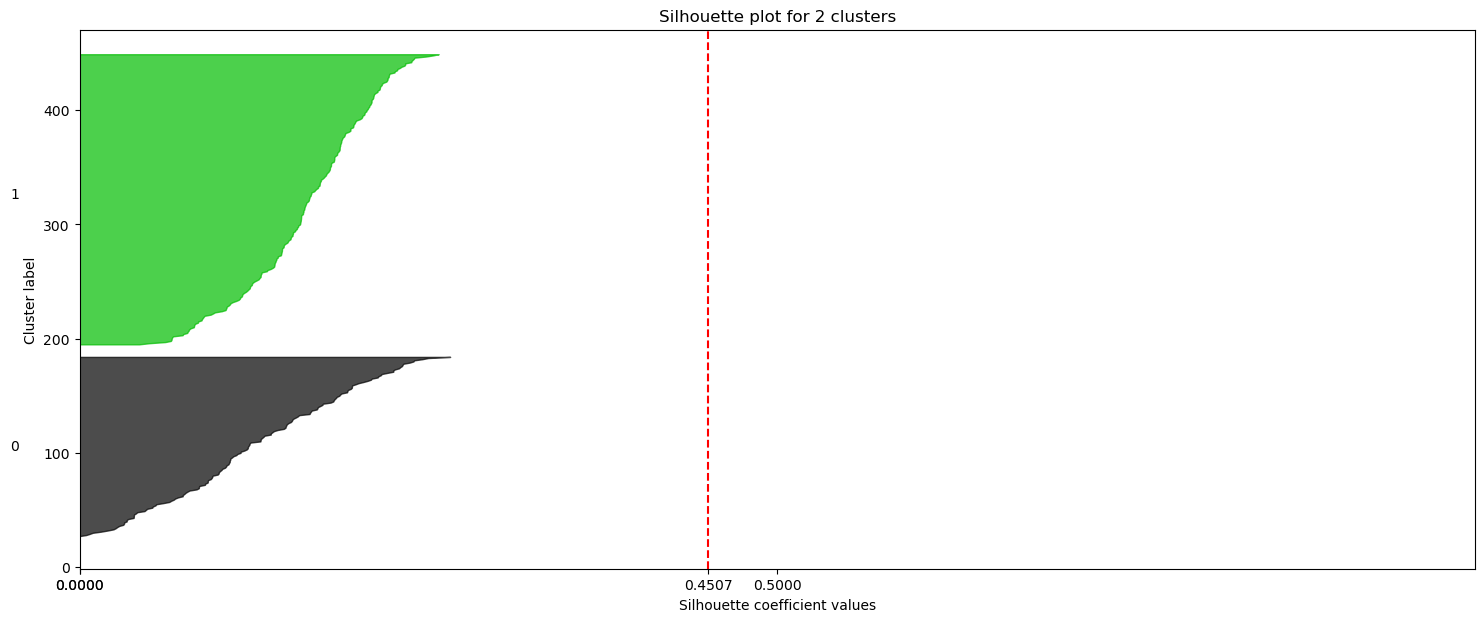

In [37]:
sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
clusters = mejor_num_clusters

ax1.set_xlim([0, 1])

y_lower = 20 
for i in range(clusters):

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  

ax1.set_title(f"Silhouette plot for {clusters} clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=mejor_silueta, color="red", linestyle="--")
ax1.set_xticks([0, 0, mejor_silueta, 0.5])


plt.show()

Por, vamos a graficar los clusters creados por K-Means. Esto lo hacemos con el fin de saber cómo están configurados y que formas tomaron.

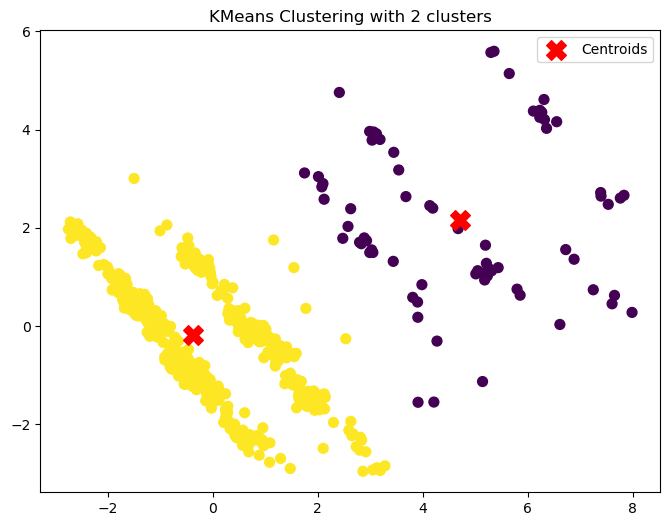

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=best_model.labels_, cmap='viridis', s=50)

centers = best_model.cluster_centers_
centers_reduced = pca.transform(centers) 
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', s=200, marker='X', label='Centroids')

plt.title(f'KMeans Clustering with {mejor_num_clusters} clusters')
plt.legend()
plt.show()

Como se puede observar en la gráfica anterior, el conjunto amarillo tiene mayor compacidad que el conjunto morado. Esto se puede deber a que este conjunto esta constituido por aquellos datos que tienen coportamientos simialres. Por último, hay unos cuantos outliers en la gráfica que se pueden diferenciar ya que no estan cerca a ninguno de, mientras en que en el grupo morado hay una mayor separación los clusters. Estos constituyen valores extremos y cuyos comportamientos son atípicos con respecto a las agrupaciones.

## DBSCAN: Hecho por Maria Fernanda de La Hoz.


Es un algoritmo de agrupamiento basado en densidad que es útil cuando se trabaja con datos complejos, especialmente cuando los clústeres pueden tener formas arbitrarias o cuando existen puntos de ruido (outliers). A diferencia de algoritmos como K-means, DBSCAN no requiere que se especifique el número de clústeres de antemano, lo que es útil cuando no sabemos cuántos grupos existen en los datos. Esto lo hace ideal para el análisis de datos médicos en urgencias, donde los patrones en la severidad de los pacientes o en su estado de salud pueden no ser predefinidos.

A pesar de sus ventajas, DBSCAN depende fuertemente de hiperparámetros clave, entre estos eps (epsilon), que define la distancia máxima entre dos puntos para que uno sea considerado vecino del otro.

Para encontrar un buen valor de eps, usamos el gráfico de distancias más cercanas (KNN). Esto nos ayuda a identificar un punto de inflexión en la curva que indica un buen valor de eps.

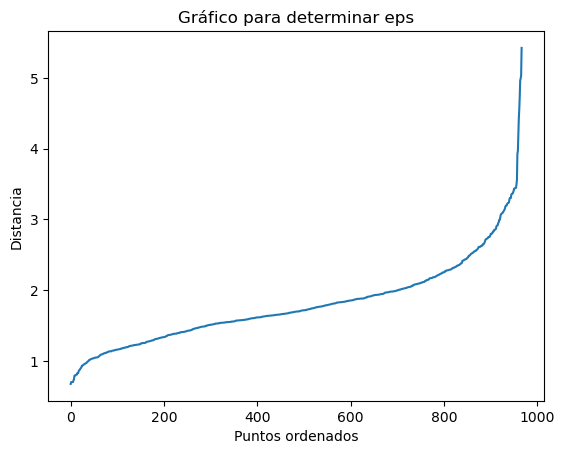

In [39]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Usamos NearestNeighbors para determinar el valor adecuado de eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Ordenamos las distancias y las graficamos
distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.title("Gráfico para determinar eps")
plt.ylabel('Distancia')
plt.xlabel('Puntos ordenados')
plt.show()

En este caso, parece que el punto de inflexión está alrededor de un valor entre 3 y 4 en el eje de las distancias. Este es el valor donde la pendiente de la curva cambia bruscamente, lo que indica una posible distancia adecuada para eps.

In [40]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=3.5, min_samples=5)  #Utilizamos el valor de eps obtenido en el paso anterior, es decir 3.5

# Aplicamos el modelo
dbscan_labels = dbscan.fit_predict(scaled_df)

# Veamos cuántos clústeres se formaron
#print(dataCopy['cluster'].value_counts())

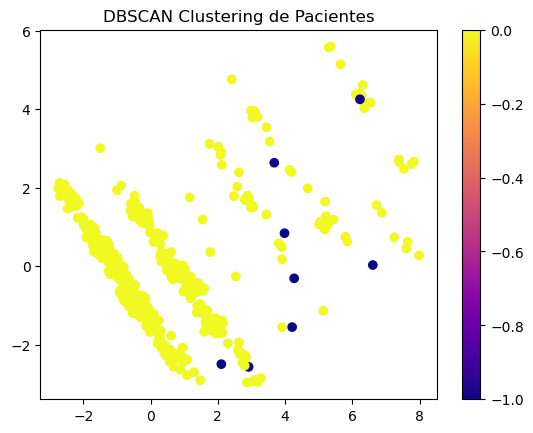

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Graficamos los clústeres
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, cmap='plasma')
plt.title('DBSCAN Clustering de Pacientes')
plt.colorbar()
plt.show()


DBSCAN es adecuado para este caso porque permite detectar clústeres de forma no esférica y manejar datos ruidosos, lo cual es una característica importante en el contexto de los datos médicos de pacientes de urgencias. Las variables como el dolor, la frecuencia cardíaca, la presión sanguínea, y otras pueden presentar patrones no lineales y agrupaciones densas, mientras que los pacientes con características muy diferentes pueden ser identificados como "ruido". La capacidad de DBSCAN para identificar puntos ruidosos es valiosa en este contexto, ya que pueden representar casos excepcionales o atípicos que requieren atención especial.

**Análisis de resultados**

El modelo DBSCAN ha revelado que los pacientes en este conjunto de datos tienden a agruparse en un gran clúster homogéneo, lo que sugiere patrones comunes en las características clínicas entre ellos. Por otro lado, algunos pacientes fueron clasificados como casos atípicos o ruidosos, lo que destaca la existencia de individuos con características poco comunes. Los resultados indican que el grupo principal comparte similitudes en sus perfiles, mientras que los puntos dispersos podrían representar variabilidad dentro de esa misma población.

En un entorno de urgencias, donde pueden aparecer casos atípicos o extremos (por ejemplo, pacientes con condiciones poco comunes), DBSCAN es capaz de tratar dichos puntos como ruido, ayudando a centrarse en los patrones más comunes. Los puntos etiquetados como ruido pueden representar pacientes con condiciones únicas que requieren una atención especial. Al identificar patrones en los tipos de pacientes que llegan a urgencias, MediAlpes puede mejorar la asignación de recursos y optimizar los tiempos de respuesta, asegurándose de que los grupos de pacientes más comunes reciban atención adecuada de manera eficiente, mientras que los casos atípicos (ruido) son gestionados de forma diferenciada.

## Modelamiento de Mean Shift: Hecho por Gabriela Soler Salomón

Este algoritmo es una técnica de clustering no supervisada que tiene como objetivo identificar centros de grupos densos en un conjunto de datos. Es efectivo ya que no se debe conocer el número de cluster previamente. El algoritmo estima la densidad de probabilidad de los datos en el espacio de características para que después los puntos se desplacen hacia la región de mayor densidad en su vecindad. Este proceso se repite hasta que los puntos convergen a los centros de los clusters, es decir, en cada iteración las posiciones de los puntos se actualizan hacia el centro de masa haque que estos ya no se muevan significativamente.

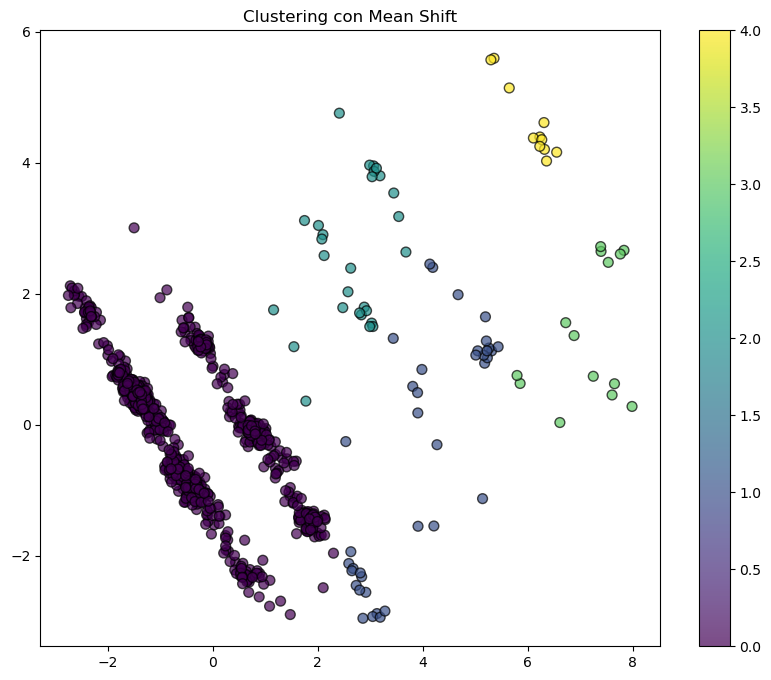

Coeficiente de Silueta para Mean Shift: 0.5228492250166494


In [42]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Aplicar Mean Shift
mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(pca_data)

# Visualización de resultados
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=mean_shift_labels, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
plt.title('Clustering con Mean Shift')
plt.colorbar()
plt.show()

# Calcular el coeficiente de silueta
silueta = silhouette_score(pca_data, mean_shift_labels)
print('Coeficiente de Silueta para Mean Shift:', silueta)

De acuerdo con la gráfica obtenida al implementar el algoritmo de Mean Shift, se obtuvieron varios clusters con diferentes densidades. En primer lugar, hay dos clusters principales, de color morado y azul, que están más densos y parecen formar patrones lineales descendentes. En segundo lugar, hay otros grupos más pequeños de colores verde, amarillo y turquesa, los cuales están dispersos alrededor del espacio, donde algunos tienen muy pocos puntos. El cluster morado muestra una alta densidad y una distribución más compacta, es decir, hay características comunes fuertes entre los pacientes de este grupo. El cluster azul, muestra una estructura similar pero con una dispersión más grande y menos denso. Por último, los clusters más pequeños pueden representar subgrupos de datos con características únicas que los distinguen del resto. 

El valor de la silueta, 0.5228, indica que, si bien la calidad del clustering no es tan alta, agrupa una parte significativa de los datos de manera correcta y separada del resto de los grupos. Así, los dos clusters grandes pueden representar condiciones comunes o típicas que se presentan en urgencias, mientras que los clusters menores pueden mostrar aquellos casos atípicos o condiciones especiales que requieran una atención diferenciada o priorización en el triage. 

## Exportación de datos

Para efectos de este proyecto, hemos escogido el modelo de Mean_Shift ya que es aquel que tiene el mayor coeficiente de silueta y realmente crea una buena cantidad de grupos bien definidos que servirán para la identificación de patrones en el triaje para asignar correctamente a los pacientes a los grupos. Para hacer esto, vamos a devolver la transformación que le habíamos hecho a los datos.

In [43]:
scaled_df.head()

,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,...,KTAS_Enfermera,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2
0,-0.205882,0.0,0.0,0.571429,0.5,0.444444,0.0,-0.500000,-1.0,1.0,...,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.764706,0.0,0.0,0.285714,0.0,-0.266667,0.0,-0.333333,0.0,6.0,...,0.0,6.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.147059,0.0,0.0,-0.857143,-1.0,0.088889,0.0,-0.166667,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,0.147059,0.0,0.0,-0.285714,-0.5,-0.266667,0.0,0.000000,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.323529,0.0,-1.0,0.371429,-0.5,2.133333,0.0,2.666667,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
scaler = joblib.load('robust_scaler.joblib')
data_original = scaler.inverse_transform(scaled_data)
scaled_df_original = pd.DataFrame(data_original, columns=dataCopy.columns)
scaled_df_original["Grupo"] = [i + 1 for i in mean_shift_labels]
dataCopy['Grupo'] = [i + 1 for i in mean_shift_labels]

In [45]:
scaled_df_original.head()

,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,...,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2,Grupo
0,49.0,0.0,1.0,150.0,90.0,92.0,20.0,36.2,2.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,30.0,0.0,1.0,140.0,80.0,76.0,20.0,36.3,3.0,7.0,...,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5
2,61.0,0.0,1.0,100.0,60.0,84.0,20.0,36.4,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,61.0,0.0,1.0,120.0,70.0,76.0,20.0,36.5,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,67.0,0.0,0.0,143.0,70.0,130.0,20.0,38.1,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [46]:
dataCopy.head()

,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,...,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2,Grupo
0,49,0,1,150.0,90.0,92.0,20.0,36.2,2,2,...,1,True,False,False,False,False,False,False,True,1
1,30,0,1,140.0,80.0,76.0,20.0,36.3,3,7,...,6,False,False,True,False,False,False,False,True,5
2,61,0,1,100.0,60.0,84.0,20.0,36.4,4,1,...,0,False,True,False,False,False,False,True,False,1
3,61,0,1,120.0,70.0,76.0,20.0,36.5,4,1,...,0,False,True,False,False,False,False,False,True,1
4,67,0,0,143.0,70.0,130.0,20.0,38.1,4,1,...,0,False,True,False,False,False,False,False,True,1


Luego, los vamos a exportar a un excel para poder generar el tablero del control.

In [47]:
scaled_df_original.to_excel('info_tablero_control.xlsx', header=True, index=False)